<a href="https://colab.research.google.com/github/GrichinNikita2019/yandex_praktikum_da/blob/main/assessment_of_traffic_sources/assessment_of_traffic_sources.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ источников трафика Яндекс.Афиши

Цель проекта: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.


Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.


**Задачей проекта является поиск ответов на следующие вопросы:**
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.


Выручка измеряется в условных единицах — у.е.



**План работы:**
1. Шаг 1. Загрузить данные и подготовить их к анализу,
2. Шаг 2. Рассчитать метрики (продуктовые, метрики электронной коммерции, маркетинговые) и построить графики,
3. Шаг 3. Сформулировать выводы и рекомендации

**Описание данных:**

В вашем распоряжении три датасета.
Файл **visits_log.csv** хранит лог сервера с информацией о посещениях сайта, **orders_log.csv** — информацию о заказах, а **costs.csv** — информацию о расходах на маркетинг.

**Структура visits_log.csv:**


* Uid — *уникальный идентификатор пользователя*
* Device — *категория устройства пользователя*
* Start Ts — *дата и время начала сессии*
* End Ts — *дата и время окончания сессии*
* Source Id — *идентификатор источника перехода на сайт*

**Структура orders_log.csv:**


* Uid — *уникальный идентификатор пользователя*
* Buy Ts — *дата и время заказа*
* Revenue — *сумма заказа*

**Структура costs.csv:**


* source_id — *идентификатор рекламного источника*
* dt — *дата проведения рекламной кампании*
* costs — *расходы на эту кампанию*

## Изучение данных из файла

### Импорт библиотек, настройка отображения данных и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
import pylab
import seaborn as sns

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [ ]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Изучение таблицы visits

In [ ]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Наблюдаем некрасивые заголовки таблицы: совмещение верхнего и нижнего регистра, пробелы отделяют слова, тогда как рекомендуется использовать символ нижнего подчеркивания. Исправим эти недостатки!

In [ ]:
visits.columns = visits.columns \
                       .str.lower() \
                       .str.replace(" ", "_")

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Успех - теперь у нас красивые названия переменных! Продолжим дальше изучать данные.

In [ ]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


Переменные **end_ts** и **start_ts** необходимо привести к формату **datetime**. 

Все переменные с содержанием ID (**source_id**, **uid**) предлагается оставить в тех форматах, которые есть.

Переменной **device** также подходит тип данных **object**, так что ее не трогаем.

In [ ]:
visits['start_ts'] = visits['start_ts'].astype('datetime64')
visits['end_ts'] = visits['end_ts'].astype('datetime64')

In [ ]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 32.7 MB


Заменили типы данных на более подходящие, а также опустили количество используемой памяти с 79.3 MB до 32.7 MB. Идем дальше!

In [ ]:
pd.DataFrame(round((visits.isna().mean()*100),2),
             columns = ['share_of_missing_values']) \
            .style.background_gradient('coolwarm')

,share_of_missing_values
device,0
end_ts,0
source_id,0
start_ts,0
uid,0


Ура, в данных нет пропусков! Теперь проверим данные на дубликаты.

In [ ]:
visits.duplicated().sum()

0

Дубликаты в данных также отсутствуют.

### Изучение таблицы orders

In [ ]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450


Датафрейм orders также нуждается в приведении заголовков в более приличный вид.

Повторим уже знакомую манипуляцию.

In [ ]:
orders.columns = orders.columns \
                       .str.lower() \
                       .str.replace(" ", "_")

In [ ]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450


Вот теперь красиво!

In [ ]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB


Представляется необходимым заменить тип данных для переменной buy_ts на **datetime**.

Остальные переменные в замене данных не нуждаются.

In [ ]:
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

In [ ]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Заменили типы данных на более подходящие, а также опустили количество используемой памяти с 4.4 MB до 1.2 MB.

Идем дальше: проверим есть ли в рассматриваемой таблице пропуски!

In [ ]:
pd.DataFrame(round((orders.isna().mean()*100),2),
             columns = ['share_of_missing_values']) \
            .style.background_gradient('coolwarm')

,share_of_missing_values
buy_ts,0
revenue,0
uid,0


В данной таблице также нет пропусков, как и в предыдущей.

Осталось проверить данные на дубликаты.

In [ ]:
orders.duplicated().sum()

0

И здесь дубликаты отсутствуют.

Перейдем к последней таблице - costs.

### Изучение таблицы costs

In [ ]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.200
1,1,2017-06-02,62.250
2,1,2017-06-03,36.530
3,1,2017-06-04,55.000
4,1,2017-06-05,57.080


На удивление в этой таблице все хорошо с заголовками, так что можно сразу переходить к рассмотрению типов переменных.

In [ ]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB


Здесь необходимо привести столбец dt к формату **datetime**.

Остальные переменные не нуждаются в преобразовании типов данных.

In [ ]:
costs['dt'] = costs['dt'].astype('datetime64')

In [ ]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Заменили типы данных на более подходящие, а также совсем немного опустили количество используемой памяти с 206.2 KB до 59.7 KB.

Идем дальше: посмотрим на пропуски в данных!

In [ ]:
pd.DataFrame(round((costs.isna().mean()*100),2),
             columns = ['share_of_missing_values']) \
            .style.background_gradient('coolwarm')

,share_of_missing_values
source_id,0
dt,0
costs,0


В таблице costs, как и в остальных, отсутствуют пропущенные значения.

Проверим дубликаты.

In [ ]:
costs.duplicated().sum()

0

И дубликаты отсутствуют.

**Общие выводы по разделу:**

1. На этапе предобработки был обнаружен ряд недостатков, которые были исправлены:
- Заголовки содержали одновременно символы верхнего и нижнего регистра, пробелы отделяли слова;
- Использовались неподходящие типы данных для переменных с датой и временем.
2. Благодаря замене типов данных объем используемой памяти для обработки датафреймов был значительно снижен (подробнее выше);
3. В остальном в предоставленных данных не наблюдается заметных недостатков: пропуски данных и дубликаты отсутствуют.

## Рассчет метрик и построение графиков

### Продуктовые метрики

#### DAU, WAU и MAU

**Задача**: Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках.

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Для расчета обозначенных метрик нам понадобятся следующие данные: год, месяц, неделя и день использования приложения.

In [ ]:
visits['visit_year']  = visits['start_ts'].dt.year
visits['visit_month'] = visits['start_ts'].dt.month
visits['visit_week']  = visits['start_ts'].dt.week
visits['visit_date'] = visits['start_ts'].dt.date

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Удостоверимся в том, что все верно сработало.

Посмотрим на первую строчку:
Значение "2017-12-20 17:20:00" переменной start_ts преобразовалось в 2017, 12, 51 и 2017-12-20 в колонках visit_year, visit_month, visit_week и visit_date, соответственно, что означает, что наши функции правильно отработали.

Посмотрим на данные чуть подробнее.

In [ ]:
visits['visit_year'].value_counts()

2017    196450
2018    162950
Name: visit_year, dtype: int64

В нашем распоряжении данные за два года: 2017 и 2018.

А теперь посчитаем DAU, WAU и MAU.

In [ ]:
dau_total = visits.groupby('visit_date') \
                  .agg({'uid': 'nunique'}) \
                  .mean()

In [ ]:
wau_total = visits.groupby(['visit_year', 'visit_week']) \
                  .agg({'uid': 'nunique'}) \
                  .mean()

In [ ]:
mau_total = visits.groupby(['visit_year', 'visit_month']) \
                  .agg({'uid': 'nunique'}) \
                  .mean()

In [ ]:
print("Количество уникальных пользователей в день (daily active users): {}".format(int(dau_total)))
print("Количество уникальных пользователей в неделю (weekly active users): {}".format(int(wau_total)))
print("Количество уникальных пользователей в месяц (monthly active users): {}".format(int(mau_total)))

Количество уникальных пользователей в день (daily active users): 907
Количество уникальных пользователей в неделю (weekly active users): 5716
Количество уникальных пользователей в месяц (monthly active users): 23228


Осталось лишь отобразить изменения этих метрик во времени на графиках.

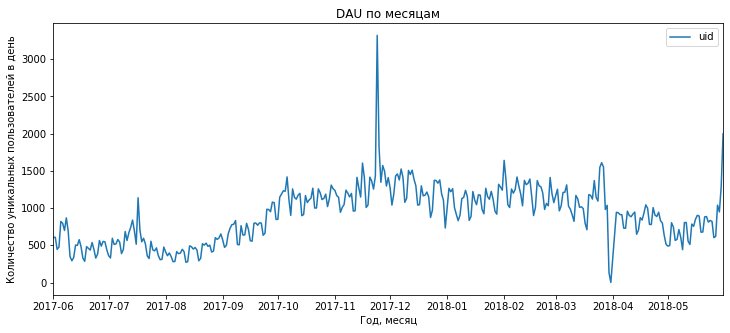

In [ ]:
visits.groupby('visit_date') \
      .agg({'uid': 'nunique'}) \
      .plot(figsize=(12,5))

plt.title('DAU по месяцам')
plt.xlabel('Год, месяц')
plt.ylabel('Количество уникальных пользователей в день')

plt.show()

In [ ]:
visits.groupby('visit_date') \
      .agg({'uid': 'nunique'}) \
      .sort_values(by='uid', ascending=False) \
      .head(1)

,uid
visit_date,
2017-11-24,3319


In [ ]:
visits.groupby('visit_date') \
      .agg({'uid': 'nunique'}) \
      .sort_values(by='uid', ascending=True) \
      .head(1)

,uid
visit_date,
2018-03-31,1


Рекордное число пользователей в день было достигнуто 2017-11-24.

Тогда как анормальное низкое число пользователей в день (1) зафиксировано 2018-03-31. Вероятнее всего в этот день сайт упал или на нем велись технические работы.

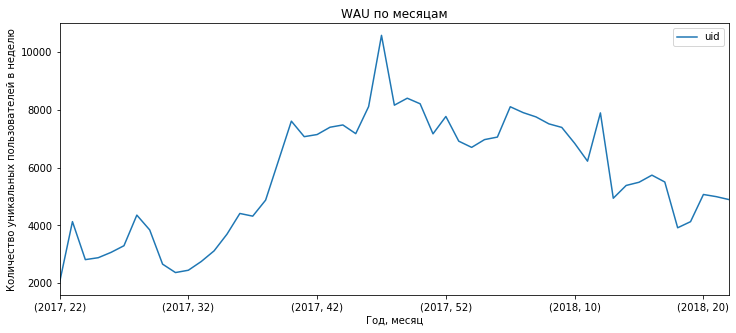

In [ ]:
visits.groupby(['visit_year', 'visit_week']) \
      .agg({'uid': 'nunique'}) \
      .plot(figsize=(12,5))

plt.title('WAU по месяцам')
plt.xlabel('Год, месяц')
plt.ylabel('Количество уникальных пользователей в неделю')

plt.show()

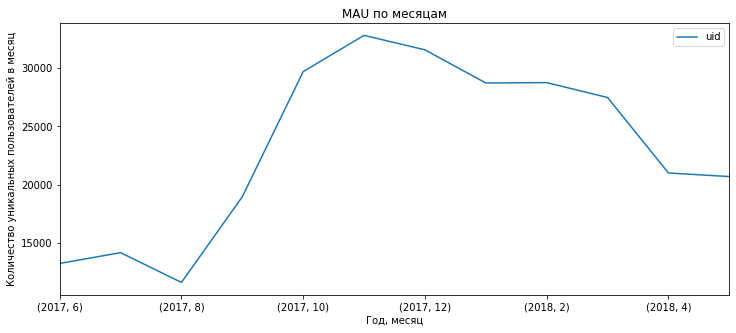

In [ ]:
visits.groupby(['visit_year', 'visit_month']) \
      .agg({'uid': 'nunique'}) \
      .plot(figsize=(12,5))

plt.title('MAU по месяцам')
plt.xlabel('Год, месяц')
plt.ylabel('Количество уникальных пользователей в месяц')

plt.show()

Как видно из графика, в первые месяцы количество пользователей в месяц не превышало 15 тысяч пользователей: MAU был достаточно низкий, особенно на фоне дальнейшего роста.

Однако с августа 2017 года MAU начал резко расти до ноября 2017 года, после чего вышел на плато с трендом на постепенное убывание количества пользователей, на котором пробыл до февраля 2018 года.

С февраля 2018 года наблюдается снижение MAU.

#### Среднее количество пользователей в день

**Задача:** Определите, сколько раз за день пользователи в среднем заходят на сайт. Постройте график, отражающий изменения метрики во времени.

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [ ]:
visits_per_user = visits.groupby('visit_date') \
                        .agg({'uid': ['count','nunique']})

visits_per_user.columns = ['n_visits', 'n_users']
visits_per_user['sess_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']

In [ ]:
print('Пользователи в среднем заходят на сайт {0:.2f} раз за день'.format(visits_per_user['n_visits'].mean())) 

Пользователи в среднем заходят на сайт 987.36 раз за день


А теперь отобразим изменение этой метрики во времени на графике.

In [ ]:
visits_per_user_month = visits.groupby(['visit_year', 'visit_month']) \
      .agg({'uid': ['count','nunique']})

visits_per_user_month.columns = ['n_visits', 'n_users']
visits_per_user_month['sess_per_user'] = visits_per_user_month['n_visits'] / visits_per_user_month['n_users']

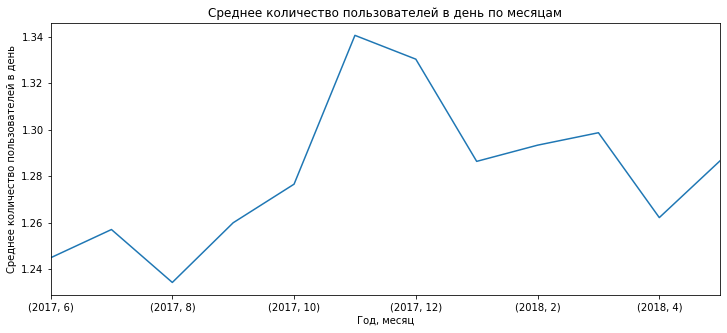

In [ ]:
visits_per_user_month['sess_per_user'].plot(figsize=(12,5))

plt.title('Среднее количество пользователей в день по месяцам')
plt.xlabel('Год, месяц')
plt.ylabel('Среднее количество пользователей в день')

plt.show()

Динамика среднего количества пользователей близка динамике MAU:

- *Низкие значения в июне-августе 2017 года*;

- *Резкий рост с августа по ноябрь 2017 года*;

- *Убывание до мая 2018 года*;

- *Подъем значения с мая 2018 года*.

#### Средняя продолжительность сессии или ASL

Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно.

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Вычислим продолжительность сессии каждого пользователя в минутах.

In [ ]:
visits['visit_duration_min'] = (visits['end_ts'] - visits['start_ts']).dt.seconds / 60

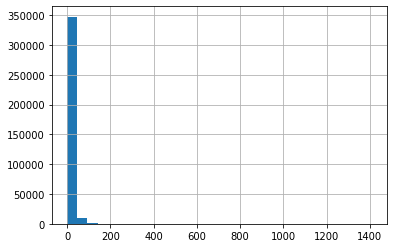

In [ ]:
visits['visit_duration_min'].hist(bins=30);

В случае, когда распределение близко к нормальному или нормальное, можно смотреть на среднюю или медиану. Наше явно не из таких, поэтому из-за жирного хвоста справа, который будет смещать значения в большую сторону, адекватнее будет опираться на моду.

In [ ]:
visits['visit_duration_min'].describe()

count   359400.000
mean        10.725
std         16.939
min          0.000
25%          2.000
50%          5.000
75%         14.000
max       1408.000
Name: visit_duration_min, dtype: float64

In [ ]:
print('Средняя продолжительность сессии: {0:.2f}'.format(float
                                                         (visits['visit_duration_min'].mode()))
     )

Средняя продолжительность сессии: 1.00


P.S. *В 10 раз ниже среднего арифмитического и на 4 минуты ниже медианного*.

#### Retention Rate

**Задача**:

Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.

Для начала необходимо определить дату первого визита для каждого пользователя.

In [ ]:
first_visit = visits.groupby(['uid'])['start_ts'] \
                    .min() \
                    .reset_index()

In [ ]:
first_visit.columns = ['uid', 'first_visit']
first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Теперь добавим дату первого визита в основновую таблицу.

In [ ]:
visits = visits.merge(first_visit)
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date,visit_duration_min,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.000,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.000,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.000,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.000,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,28.000,2018-03-09 20:05:00


Далее нам необходимо выделить месяцы визита и первого визита.

Переменная 'visit_month' уже имеется в датафрейме, однако для удобства лучше изменить формат.

In [ ]:
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date,visit_duration_min,first_visit,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,18.000,2017-12-20 17:20:00,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,28.000,2018-02-19 16:53:00,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0.000,2017-07-01 01:54:00,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,24.000,2018-03-09 20:05:00,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,2018-03-01,10,2018-03-09,28.000,2018-03-09 20:05:00,2018-03-01


Месяцы визита и первого визита успешно добавлены.

Следующим шагом нужно посчитать, как долго (сколько месяцев) с нами каждый пользователь, то есть разницу между последним визитом и первым визитом.

In [ ]:
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month'])/ np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date,visit_duration_min,first_visit,first_visit_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,18.000,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,28.000,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0.000,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,24.000,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,2018-03-01,10,2018-03-09,28.000,2018-03-09 20:05:00,2018-03-01,0


In [ ]:
visits['lifetime'].value_counts()

0     267858
1      23294
2      14833
3      11961
4       9977
5       8497
6       6834
7       5290
8       4009
9       3036
10      2193
11      1618
Name: lifetime, dtype: int64

Самые "старые" пользователи (по кторым есть данные в представленном датафрейме) в приложении уже 11 месяцев. Это значит, что в нашем когортном анализе будет представлено 12 когорт. 

Самое время их выделить - для начала посчитаем количество активных пользователей с разным сроком жизни для каждого месяца!

In [ ]:
cohort_visits = visits.groupby(['first_visit_month', 'lifetime']) \
                      .agg({'uid': 'nunique'}) \
                      .reset_index()

cohort_visits

,first_visit_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Теперь посчитаем количество активных пользователей на первый месяц жизни каждой когорты.

In [ ]:
first_month_uid = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]

In [ ]:
first_month_uid.columns = ['first_visit_month', 'first_month_uid']

In [ ]:
first_month_uid

,first_visit_month,first_month_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Добавим количество активных пользователей на момент "зарождения" каждой когорты в основную таблицу с даными по когортам - cohort_visits.

In [ ]:
cohort_visits = cohort_visits.merge(first_month_uid)

In [ ]:
cohort_visits

,first_visit_month,lifetime,uid,first_month_uid
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [ ]:
cohort_visits['retention_rate'] = cohort_visits['uid'] / cohort_visits['first_month_uid']

In [ ]:
cohort_visits

,first_visit_month,lifetime,uid,first_month_uid,retention_rate
0,2017-06-01,0,13259,13259,1.000
1,2017-06-01,1,1043,13259,0.079
2,2017-06-01,2,713,13259,0.054
3,2017-06-01,3,814,13259,0.061
4,2017-06-01,4,909,13259,0.069
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.042
74,2018-03-01,2,557,20589,0.027
75,2018-04-01,0,15709,15709,1.000
76,2018-04-01,1,760,15709,0.048


Все подготовительные работы для когортного анализа проделаны, все данные собраны в кучу - осталось только представить их наглядно представить. Для этого нужным образом сгруппируем их.

In [ ]:
visits_retention_pivot = cohort_visits.pivot_table(index = 'first_visit_month', 
                                                   columns = 'lifetime',
                                                   values = 'retention_rate',
                                                   aggfunc = 'sum')

С этим уже можно работать, однако для удобства можно представить это в процентном виде.

In [ ]:
visits_retention_pivot.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.000,0.079,0.054,0.061,0.069,0.071,0.061,0.058,0.052,0.051,0.041,0.045
2017-07-01,1.000,0.056,0.051,0.056,0.058,0.048,0.045,0.046,0.039,0.029,0.027,
2017-08-01,1.000,0.077,0.063,0.063,0.050,0.044,0.036,0.039,0.028,0.026,,
2017-09-01,1.000,0.085,0.069,0.051,0.039,0.038,0.036,0.024,0.023,,,
2017-10-01,1.000,0.079,0.052,0.039,0.034,0.032,0.021,0.020,,,,
2017-11-01,1.000,0.078,0.044,0.039,0.034,0.023,0.022,,,,,
2017-12-01,1.000,0.056,0.038,0.031,0.020,0.019,,,,,,
2018-01-01,1.000,0.060,0.039,0.025,0.020,,,,,,,
2018-02-01,1.000,0.057,0.025,0.020,,,,,,,,


По этой таблице уже можно делать выводы, однако прежде построим красивый график!

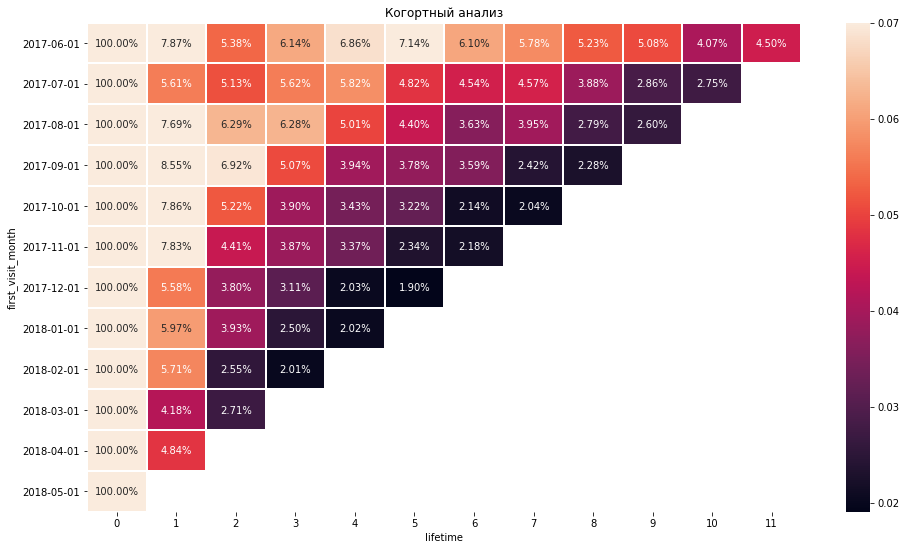

In [ ]:
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(visits_retention_pivot,annot=True, fmt='.2%', linewidths=1, linecolor='white', vmax=0.07)
ax.set_yticklabels(visits_retention_pivot.index.date)
plt.show()

**Выводы по графику:**

1. Лишь небольшой процент людей возвращаются в приложение на первый месяц жизни когорты (от 4,18 до 8,55). Для приложения, специфика которого заключается в ознакомлении с досуговыми предложениями, это представляется хорошим значением показателя (однако сложно точно судить без наличия бенчмарка по категории).
2. Начиная с первого месяца жизни и далее Retention Rate падает незначительно от месяца к месяцу.
3. Наибольший уровень удержания отмечается в когорте "2017-06-01": даже на 11 месяц жизни Retention Rate выше, чем у остальных когорт на их последний месяц жизни (на момент формирования датафрейма).
4. Также высокие значения показателя удержания к 3 месяцу жизни наблюдаются среди когорт 2017-07-01 и 2017-08-01.
5. В целом наблюдается тренд на снижение уровня удержания в более молодых когортах по сравнению с более старыми.

### Метрики электронной коммерции

#### Среднее время от первого визита до покупки

**Задача**:

Исследовать, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно.

In [ ]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450


In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date,visit_duration_min,first_visit,first_visit_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,18.000,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,28.000,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0.000,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,24.000,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,2018-03-01,10,2018-03-09,28.000,2018-03-09 20:05:00,2018-03-01,0


Для начала объединим данные о первых визитах и покупках в одну таблицу.

In [ ]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                                   .rename(columns={'start_ts':'first_visit_date'})\
                                   .reset_index()

In [ ]:
first_visit.head()

,uid,first_visit_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [ ]:
first_order = orders.groupby('uid').agg({'buy_ts':'min'})\
                                   .rename(columns={'buy_ts':'first_buy_date'})\
                                   .reset_index()

In [ ]:
first_order

,uid,first_buy_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [ ]:
first_visit_and_order = first_visit.merge(first_order, on='uid', how='inner')

In [ ]:
first_visit_and_order.head()

,uid,first_visit_date,first_buy_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Теперь, когда все данные собраны вместе, посчитаем время в минутах, которое проходило между первым посещением сайта и первой покупкой.

In [ ]:
first_visit_and_order['time_for_buy'] = (first_visit_and_order['first_buy_date']
                                         - first_visit_and_order['first_visit_date']).dt.seconds/ 60

In [ ]:
first_visit_and_order.head()

,uid,first_visit_date,first_buy_date,time_for_buy
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.000
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.000
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.000
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.000
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.000


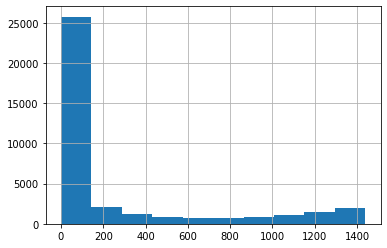

In [ ]:
first_visit_and_order['time_for_buy'].hist(bins=10);

Судя по распределению, надежнее всего в очередной раз будет опереться на моду.

In [ ]:
first_visit_and_order['time_for_buy'].mode()

0   1.000
dtype: float64

In [ ]:
first_visit_and_order['time_for_buy'].value_counts()

1.000      2669
0.000      2467
2.000      2123
3.000      1700
4.000      1474
           ... 
915.000       1
756.000       1
626.000       1
729.000       1
867.000       1
Name: time_for_buy, Length: 1435, dtype: int64

Чаще всего люди совершают покупку в течение 1 минуты (2669 пользователей из всех совершивших хотя бы 1 покупку) или раньше (показательно, что на втором месте по распространенности покупки совершенные менее, чем за минуту, то есть за 0 минут).

Но для интереса взглянем и на другие меры средней тенденции. 

In [ ]:
first_visit_and_order['time_for_buy'].describe()

count   36523.000
mean      249.165
std       429.743
min         0.000
25%         4.000
50%        16.000
75%       252.000
max      1439.000
Name: time_for_buy, dtype: float64

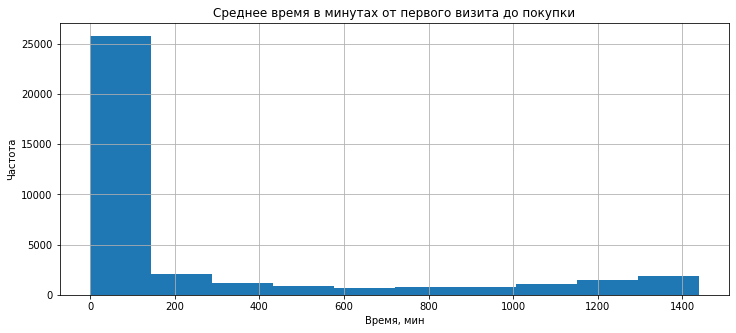

In [ ]:
first_visit_and_order['time_for_buy'].hist(figsize=(12,5))

plt.title('Среднее время в минутах от первого визита до покупки')
plt.xlabel('Время, мин')
plt.ylabel('Частота')

plt.show()

Из-за слишком жирного хвоста на среднее арифмитическую и даже на медиану мало смысла смотреть.

**Основной вывод**: Чаще всего люди совершают покупку в течение 1 минуты или раньше.

#### Среднее количество покупок на одного покупателя

**Задача**: Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно.

В этот раз нам понадобиться преимущественно таблица orders, однако в нее необходимо добавить информацию о первом визите - благо таблица с такой информацией у нас уже появилась на предыдущих этапах.

In [ ]:
orders_and_visits = orders.merge(first_visit, on='uid', how='inner')

In [ ]:
orders_and_visits.head()

,buy_ts,revenue,uid,first_visit_date
0,2017-06-01 00:10:00,17.000,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.550,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.370,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.550,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.370,14200605875248379450,2017-06-01 07:31:00


In [ ]:
orders_and_visits['buy_day'] = orders_and_visits['buy_ts'].dt.day
orders_and_visits['week_month'] = orders_and_visits['buy_ts'].dt.week
orders_and_visits['buy_month'] = orders_and_visits['buy_ts'].dt.month

In [ ]:
buy_per_day = orders_and_visits.groupby(['buy_day']).agg({'uid':['count','nunique']})
buy_per_week = orders_and_visits.groupby(['week_month']).agg({'uid':['count','nunique']})
buy_per_month = orders_and_visits.groupby(['buy_month']).agg({'uid':['count','nunique']})

In [ ]:
buy_per_day.columns = [''] * len(buy_per_day.columns)
buy_per_week.columns = [''] * len(buy_per_week.columns)
buy_per_month.columns = [''] * len(buy_per_month.columns)

In [ ]:
buy_per_day.columns = ['purchases','buyers']
buy_per_week.columns = ['purchases','buyers']
buy_per_month.columns = ['purchases','buyers']

In [ ]:
buy_per_day['purchases_per_buyer'] = buy_per_day['purchases'] / buy_per_day['buyers']
buy_per_week['purchases_per_buyer'] = buy_per_week['purchases'] / buy_per_week['buyers']
buy_per_month['purchases_per_buyer'] = buy_per_month['purchases'] / buy_per_month['buyers']

In [ ]:
avg_purchases_per_buyer = pd.DataFrame()

In [ ]:
avg_purchases_per_buyer['purchases_per_buyer_by_day'] = buy_per_day['purchases_per_buyer'].describe()
avg_purchases_per_buyer['purchases_per_buyer_by_week'] = buy_per_week['purchases_per_buyer'].describe()
avg_purchases_per_buyer['purchases_per_buyer_by_month'] = buy_per_month['purchases_per_buyer'].describe()

In [ ]:
avg_purchases_per_buyer

,purchases_per_buyer_by_day,purchases_per_buyer_by_week,purchases_per_buyer_by_month
count,31.000,52.000,12.000
mean,1.119,1.161,1.223
std,0.016,0.037,0.031
min,1.082,1.082,1.164
25%,1.109,1.141,1.207
50%,1.120,1.158,1.227
75%,1.129,1.183,1.241
max,1.146,1.259,1.274


**Основной вывод:**

В среднем на сайте на одного посетителя приходится 1.119 покупки в день, 1.161 - в неделю, 1.223 - в месяц.

#### Средний чек или Average Order Value

**Задача:** Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени.

In [ ]:
orders_and_visits['revenue'].describe()

count   50415.000
mean        5.000
std        21.818
min         0.000
25%         1.220
50%         2.500
75%         4.890
max      2633.280
Name: revenue, dtype: float64

In [ ]:
orders_and_visits['revenue'].mode()

0   1.830
dtype: float64

In [ ]:
orders_and_visits.head()

,buy_ts,revenue,uid,first_visit_date,buy_day,week_month,buy_month
0,2017-06-01 00:10:00,17.000,10329302124590727494,2017-06-01 00:09:00,1,22,6
1,2017-06-01 00:25:00,0.550,11627257723692907447,2017-06-01 00:14:00,1,22,6
2,2017-06-01 00:27:00,0.370,17903680561304213844,2017-06-01 00:25:00,1,22,6
3,2017-06-01 00:29:00,0.550,16109239769442553005,2017-06-01 00:14:00,1,22,6
4,2017-06-01 07:58:00,0.370,14200605875248379450,2017-06-01 07:31:00,1,22,6


In [ ]:
mean_buy_by_month = orders_and_visits.groupby('buy_month') \
                                     .agg({'revenue': 'mean'})

In [ ]:
mean_buy_by_month.sort_values(by='revenue',ascending=False)

,revenue
buy_month,
12,5.852
9,5.416
3,5.414
7,5.307
4,5.151
10,4.928
8,4.847
2,4.840
11,4.784


In [ ]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', \
              'July', 'August', 'September', 'October', 'November', 'December']

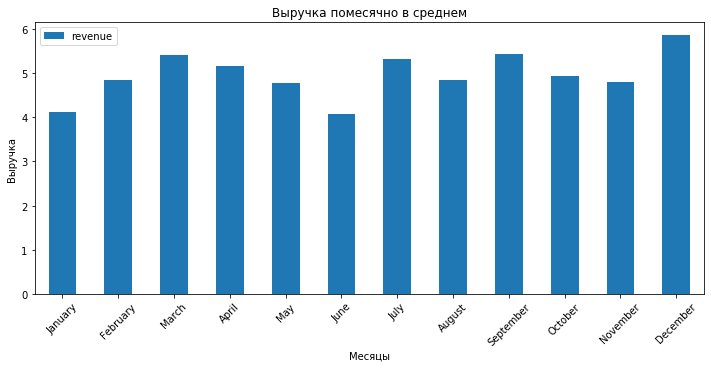

In [ ]:
ax = mean_buy_by_month.plot(kind='bar', figsize=(12,5))

ax.set_xticklabels(month_list, rotation=45)
plt.title('Выручка помесячно в среднем')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Выручка')

plt.show()

**Выводы:**

1. Наибольший средний чек наблюдается в Декабре, что предположительно связано с новогодними расходами.
2. Также высокий средний чек в следующие месяцы: Сентябрь, Март и Июль.
3. Наименьший средний чек приходится на Июнь.

#### LTV

**Задача:**

Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике;

In [ ]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]') 

In [ ]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [ ]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [ ]:
orders_new = pd.merge(orders,first_orders, on='uid')

In [ ]:
cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

In [ ]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [ ]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [ ]:
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).round()

output.cumsum(axis=1).fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.000,5.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000,13.000,13.000
2017-07-01,6.000,6.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,
2017-08-01,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,,
2017-09-01,6.000,7.000,8.000,12.000,12.000,13.000,14.000,14.000,14.000,,,
2017-10-01,5.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,,,,
2017-11-01,5.000,5.000,5.000,5.000,5.000,5.000,5.000,,,,,
2017-12-01,5.000,5.000,6.000,7.000,7.000,7.000,,,,,,
2018-01-01,4.000,4.000,4.000,4.000,4.000,,,,,,,
2018-02-01,4.000,4.000,4.000,4.000,,,,,,,,


Теперь отфильтруем когорты, оставив только те, которые прожили более 6 месяцев, а также оставим период в 6 месяцев, чтобы сравнить эффективность когорт за равный период.

In [ ]:
output = output.cumsum(axis=1) \
               .query('first_order_month < "2017-12-01"') \
               .T \
               .dropna() \
               .T

In [ ]:
output

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,5.000,5.000,5.000,6.000,7.000,8.000,9.000
2017-07-01,6.000,6.000,7.000,7.000,7.000,7.000,7.000
2017-08-01,5.000,5.000,5.000,5.000,5.000,5.000,5.000
2017-09-01,6.000,7.000,8.000,12.000,12.000,13.000,14.000
2017-10-01,5.000,6.000,6.000,6.000,6.000,6.000,6.000
2017-11-01,5.000,5.000,5.000,5.000,5.000,5.000,5.000


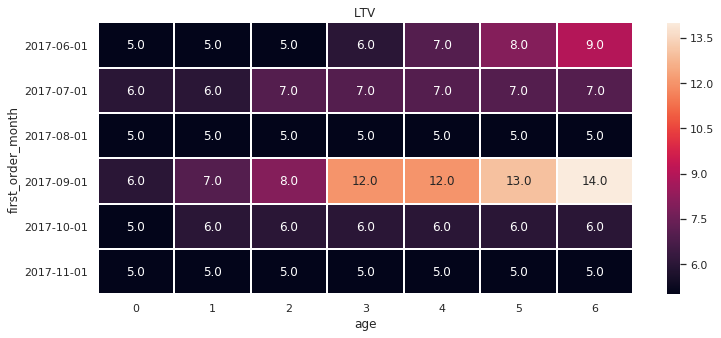

In [ ]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (12,5))
plt.title('LTV')
ax = sns.heatmap(output, annot=True, fmt='.1f', linewidths=1, linecolor='white')
ax.set_yticklabels(output.index.date)
plt.show()

**Основные выводы:**

1. Наиболее высокие значения LTV к 6 месяцу жизни когорты демонстрируют когорта от 2017-09-01.
2. Также высокие значения LTV имеет когорта от 2017-06-01.
3. Значения остальных когорт к 6 месяцу показывают приблизительно одинаковые значения: от 5 до 7.

### Маркетинговые метрики

#### Общая сумма расходов на маркетинг

**Задача:**

Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени.

In [ ]:
costs['costs'].sum()

329131.62

In [ ]:
costs_by_source = costs.groupby('source_id')['costs'] \
                       .sum() \
                       .reset_index()

In [ ]:
costs_by_source['in_percents'] = costs_by_source['costs'] / 329131.62 * 100

In [ ]:
costs_by_source.sort_values('in_percents', ascending = False)

,source_id,costs,in_percents
2,3,141321.630,42.938
3,4,61073.600,18.556
4,5,51757.100,15.725
1,2,42806.040,13.006
0,1,20833.270,6.330
6,10,5822.490,1.769
5,9,5517.490,1.676


Наибольший объем расходов приходится на источник 3.

In [ ]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date

In [ ]:
costs_by_month = costs.groupby('costs_month')['costs'] \
                      .sum() \
                      .reset_index()

costs_by_month

,costs_month,costs
0,2017-06-01,18015.000
1,2017-07-01,18240.590
2,2017-08-01,14790.540
3,2017-09-01,24368.910
4,2017-10-01,36322.880
5,2017-11-01,37907.880
6,2017-12-01,38315.350
7,2018-01-01,33518.520
8,2018-02-01,32723.030
9,2018-03-01,30415.270


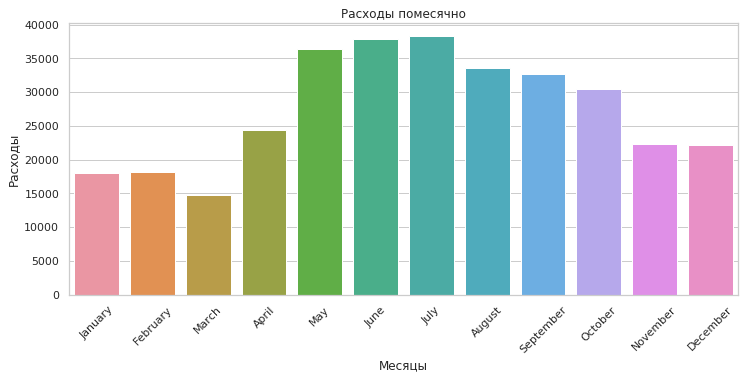

In [ ]:
plt.figure(figsize = (12,5))
ax = sns.barplot(x="costs_month", y="costs", data=costs_by_month)
ax.set_xticklabels(month_list, rotation=45)
plt.title('Расходы помесячно')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Расходы')
plt.show()

**Выводы:**

1. С Апреля наблюдается возрастание расходов, которое продолжается до Июля.
2. На Июль приходится пик расходов.
3. С Июля уровень расходов плавно снижается до Октября, после чего с Ноября расходы снижаются еще сильнее.

#### Cтоимость привлечения клиента (CAC)

**Задача:** Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках.

In [ ]:
costs_by_source = costs.groupby('source_id') \
                       .agg({'costs':'sum'})

costs_by_source.reset_index()

,source_id,costs
0,1,20833.270
1,2,42806.040
2,3,141321.630
3,4,61073.600
4,5,51757.100
5,9,5517.490
6,10,5822.490


In [ ]:
visits_by_source = visits.query('start_ts == first_visit')

customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')) \
                             .groupby('source_id') \
                             .agg({'uid':'nunique'}) \
                             .rename(columns={'uid':'customers'})

In [ ]:
customers_by_source.reset_index()

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [ ]:
cac = customers_by_source.join(costs_by_source).reset_index()
cac

,source_id,customers,costs
0,1,2899,20833.270
1,2,3506,42806.040
2,3,10473,141321.630
3,4,10296,61073.600
4,5,6931,51757.100
5,7,1,nan
6,9,1088,5517.490
7,10,1329,5822.490


In [ ]:
cac = cac.fillna(0)

In [ ]:
cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = True)

,source_id,customers,costs,cac
5,7,1,0.000,0.000
7,10,1329,5822.490,4.381
6,9,1088,5517.490,5.071
3,4,10296,61073.600,5.932
0,1,2899,20833.270,7.186
4,5,6931,51757.100,7.467
1,2,3506,42806.040,12.209
2,3,10473,141321.630,13.494


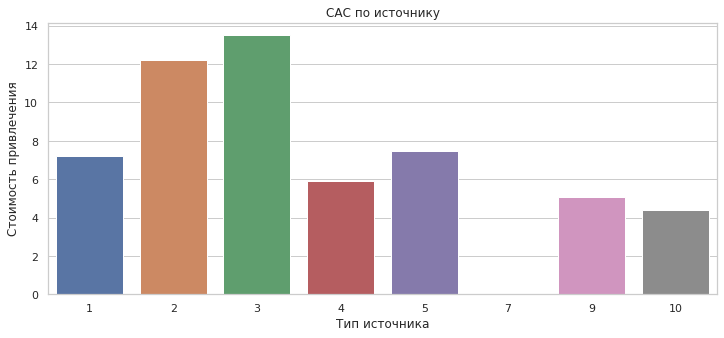

In [ ]:
plt.figure(figsize = (12,5))
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

**Основные выводы:**

1. По источнику 7 данных недостаточно для анализа.
2. В тройку наиболее дешевых источников входят источники 10, 9 и 4.
3. Наиболее дорогие: 2 и 3.

#### ROMI

**Задача:**

Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.

А теперь для подсчета ROMI предлагаю собрать мегазорда из всех предыдущих этапов.

In [ ]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [ ]:
visits.columns = visits.columns \
                       .str.lower() \
                       .str.replace(" ", "_")

In [ ]:
orders.columns = orders.columns \
                       .str.lower() \
                       .str.replace(" ", "_")

In [ ]:
visits_sorted = visits.sort_values(by='start_ts')

costs_by_sources = costs.groupby('source_id').agg({'costs': 'sum'})
first_source_by_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})
buyers_by_sources = orders.merge(first_source_by_user, on='uid')
buyers_by_sources = buyers_by_sources.groupby('source_id').agg({'uid': 'nunique'})
uid_by_sources = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})

revenue_by_sources = orders.merge(first_source_by_user, on='uid')
revenue_by_sources = revenue_by_sources.groupby('source_id').agg({'revenue': 'sum'})

megazord = pd.concat([costs_by_sources, revenue_by_sources, 
                                      uid_by_sources, buyers_by_sources],axis=1).fillna(0)

megazord.columns = ['costs', 'revenue', 'uid', 'users']
megazord['cac'] = megazord['costs'] / megazord['users']
megazord['cac'] = megazord['cac'].round(2)

In [ ]:
margin_rate = 1
megazord['gp'] = megazord['revenue'] * margin_rate
megazord['ltv'] = megazord['gp'] / megazord['users']
megazord['romi'] = megazord['ltv'] / megazord['cac']
df = megazord.reset_index()
romi_by_source = df.pivot_table(index='source_id', values=['revenue','romi', 'ltv', 'cac', 'costs', 'gp', 'users'])
romi_by_source.round(2)

,cac,costs,gp,ltv,revenue,romi,users
source_id,,,,,,,
1,7.190,20833.270,31090.550,10.720,31090.550,1.490,2899.000
2,12.210,42806.040,46923.610,13.380,46923.610,1.100,3506.000
3,13.490,141321.630,54511.240,5.200,54511.240,0.390,10473.000
4,5.930,61073.600,56696.830,5.510,56696.830,0.930,10296.000
5,7.470,51757.100,52624.020,7.590,52624.020,1.020,6931.000
6,nan,0.000,0.000,nan,0.000,nan,0.000
7,0.000,0.000,1.220,1.220,1.220,inf,1.000
9,5.070,5517.490,5759.400,5.290,5759.400,1.040,1088.000
10,4.380,5822.490,4450.330,3.350,4450.330,0.760,1329.000


По источникам 6 и 7 данных недостаточно для нализа.

Наиболее окупившийся источник трафика - 1 (ROMI составил 1.490 при маржинальности 1). 

Источники 2, 9 и 5 также окупились.

Вклад в остальные источники трафика не окупился.

## Общий вывод

**На этапе предобработки был обнаружен ряд недостатков, которые были исправлены:**

1. Заголовки содержали одновременно символы верхнего и нижнего регистра, пробелы отделяли слова;
2. Использовались неподходящие типы данных для переменных с датой и временем.

Благодаря замене типов данных объем используемой памяти для обработки датафреймов был значительно снижен.

В остальном в предоставленных данных не наблюдалось заметных недостатков: пропуски данных и дубликаты отсутствуют.

**DAU** - Количество уникальных пользователей в день (daily active users): 907

**WAU** - Количество уникальных пользователей в неделю (weekly active users): 5716

**MAU** - Количество уникальных пользователей в месяц (monthly active users): 23228

**Относительно динамики количества пользователей можно заключить следующее:**

1. Как видно из графика, в первые месяцы количество пользователей в месяц не превышало 15 тысяч пользователей: MAU был достаточно низкий, особенно на фоне дальнейшего роста.

2. Однако с августа 2017 года MAU начал резко расти до ноября 2017 года, после чего вышел на плато с трендом на постепенное убывание количества пользователей, на котором пробыл до февраля 2018 года.

3. С февраля 2018 года наблюдается снижение MAU.

**Пользователи в среднем заходят на сайт 987.36 раз за день**.

Динамика среднего количества пользователей близка динамике MAU:

- *Низкие значения в июне-августе 2017 года*;

- *Резкий рост с августа по ноябрь 2017 года*;

- *Убывание до мая 2018 года*;

- *Подъем значения с мая 2018 года*.

**Средняя продолжительность сессии на сайте: 1.00**

**Относительно удержания пользователей на сайте выводы следующие**:

- Лишь небольшой процент людей возвращаются в приложение на первый месяц жизни когорты (от 4,18 до 8,55). Для приложения, специфика которого заключается в ознакомлении с досуговыми предложениями, это представляется хорошим значением показателя (однако сложно точно судить без наличия бенчмарка по категории).
- Начиная с первого месяца жизни и далее Retention Rate падает незначительно от месяца к месяцу.
- Наибольший уровень удержания отмечается в когорте "2017-06-01": даже на 11 месяц жизни Retention Rate выше, чем у остальных когорт на их последний месяц жизни (на момент формирования датафрейма).
- Также высокие значения показателя удержания к 3 месяцу жизни наблюдаются среди когорт 2017-07-01 и 2017-08-01.
- В целом наблюдается тренд на снижение уровня удержания в более молодых когортах по сравнению с более старыми.

**Чаще всего люди совершают покупку в течение 1 минуты** (*2669 пользователей из всех совершивших хотя бы 1 покупку*) **или раньше** (*показательно, что на втором месте по распространенности покупки совершенные менее, чем за минуту, то есть за 0 минут*).

**В среднем на сайте на одного посетителя приходится 1.119 покупки в день, 1.161 - в неделю, 1.223 - в месяц.**.

**Относительно среднего чека можно заключить, что**:

1. Наибольший средний чек наблюдается в Декабре, что предположительно связано с новогодними расходами.
2. Также высокий средний чек в следующие месяцы: Сентябрь, Март и Июль.
3. Наименьший средний чек приходится на Июнь.

**По поводу LTV**:

- Наиболее высокие значения LTV к 6 месяцу жизни когорты демонстрируют когорты от 2017-06-01 и 2017-09-01.

**Выводы относительно общей суммы расходов на маркетинг:**

1. С Апреля наблюдается возрастание расходов, которое продолжается до Июля.
2. На Июль приходится пик расходов.
3. С Июля уровень расходов плавно снижается до Октября, после чего с Ноября расходы снижаются еще сильнее.

**Анализ стоимости привлечения клиентов (CAC) в разрезе рекламных источников трафика показал, что**:

1. В тройку наиболее дешевых источников входят источники 10, 9 и 4.
2. Наиболее дорогие: 2 и 3.

**ROMI:**

Наиболее окупившийся источник трафика - 1 (ROMI составил 1.490 при маржинальности 0.5). 

Источники 2, 9 и 5 также окупились.

Вклад в остальные источники трафика не окупился.


**Рекомендации:**
1. В последующих рекламных кампаниях рекомендуется перераспределить бюджеты на более эффективные источники, а именно 1 (в первую очередь), 2, 9 и 5. В свою очередь, от источника 3 рекомендуется отказаться или значительно снизить бюджет. Источники 4 и 10 можно оставить в рекламном сплите, однако рекомендуется проработать оптимизацию рекламных/маркетинговых размещений для повышения уровня окупаемости источников.
2. Большая часть пользователей (около 90-95% аудитории) прекращает использовать приложение уже на первый месяц жизни когорты, из-за чего рекомендуется продумать механики удержания пользователей в приложении, например, добавить дополниельные виды активности, стимулирующие пользователей к возвращению. Или добавить элементы геймификации, например, отмечать посещенные мероприятия в своем аккаунте и получать за это "досуговый опыт"